In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time
import random
import wandb
import torch
wandb.login()

from evaluation.helpers import set_size

torch.manual_seed(42)
np.random.seed(42)

/home/zenon/.local/share/miniconda3/lib/python3.7/site-packages/requests/__init__.py:104: RequestsDependencyWarning: urllib3 (1.26.13) or chardet (5.1.0)/charset_normalizer (2.0.4) doesn't match a supported version!
  RequestsDependencyWarning)
wandb: Currently logged in as: e1527193 (flower-classification). Use `wandb login --relogin` to force relogin


# Download Metrics from WandB

In [2]:
api = wandb.Api()

# Project is specified by <entity/project-name>
runs = api.runs("flower-classification/pytorch-sweeps-demo")

summary_list, config_list, name_list = [], [], []
for run in runs: 
    # .summary contains the output keys/values for metrics like accuracy.
    #  We call ._json_dict to omit large files 
    summary_list.append(run.summary._json_dict)

    # .config contains the hyperparameters.
    #  We remove special values that start with _.
    config_list.append(
        {k: v for k,v in run.config.items()
          if not k.startswith('_')})

    # .name is the human-readable name of the run.
    name_list.append(run.name)

runs_df = pd.DataFrame({
    "summary": summary_list,
    "config": config_list,
    "name": name_list
    })

runs_df.to_csv("hyp-metrics.csv")

# Transform Metrics

The column `summary` contains most of the metrics we are interested in (`test/precision`,…) but all of the metrics are in a dictionary in this column.

In [3]:
df = pd.read_csv('hyp-metrics.csv',
                 delimiter=',')
df['summary'] = df['summary'].map(eval)
df['config'] = df['config'].map(eval)
df = df.join(pd.json_normalize(df['summary'])).drop('summary', axis='columns')
df = df.join(pd.json_normalize(df['config'])).drop('config', axis='columns')
df

,Unnamed: 0,name,test/epoch_acc,test/precision,test/epoch_loss,train/epoch_acc,_step,epoch,_timestamp,test/f1-score,...,test/batch_loss,eps,gamma,epochs,beta_one,beta_two,optimizer,step_size,batch_size,learning_rate
0,0,fiery-sweep-26,0.733333,0.828571,0.566462,0.823096,2059,9,1.680693e+09,0.707317,...,NaN,1.000000e-01,0.1,10,0.99,0.900,adam,3,4,0.0003
1,1,radiant-sweep-25,0.722222,0.685185,0.645458,0.712531,1039,9,1.680693e+09,0.747475,...,NaN,1.000000e+00,0.5,10,0.99,0.900,adam,2,8,0.0003
2,2,blooming-sweep-24,0.888889,0.935484,0.348129,0.998771,1039,9,1.680692e+09,0.852941,...,NaN,1.000000e-08,0.5,10,0.90,0.999,sgd,5,8,0.0030
3,3,visionary-sweep-23,0.800000,0.760870,0.555318,0.835381,529,9,1.680692e+09,0.795455,...,NaN,1.000000e+00,0.1,10,0.90,0.900,sgd,2,16,0.0003
4,4,ancient-sweep-22,0.577778,0.589744,1.560271,0.557740,410,1,1.680692e+09,0.707692,...,NaN,1.000000e-08,0.5,10,0.90,0.990,adam,7,4,0.0100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133,133,different-sweep-5,0.822222,0.945946,0.493642,0.821867,1159,9,1.678732e+09,0.813953,...,0.506896,NaN,0.5,10,NaN,NaN,sgd,3,8,0.0001
134,134,wise-sweep-4,0.855556,0.825000,0.548264,0.812039,1159,9,1.678731e+09,0.835443,...,0.515937,NaN,0.5,10,NaN,NaN,sgd,2,8,0.0001
135,135,misty-sweep-3,0.877778,0.939394,0.241948,0.996314,2289,9,1.678731e+09,0.849315,...,1.758836,NaN,0.5,10,NaN,NaN,sgd,3,4,0.0030
136,136,unique-sweep-2,0.811111,0.838710,0.479234,0.832924,1159,9,1.678730e+09,0.753623,...,0.455120,NaN,0.1,10,NaN,NaN,sgd,3,8,0.0003


In [4]:
df['learning_rate'].value_counts().sort_values(0)


/home/zenon/.local/share/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of Series.sort_values will be keyword-only
  """Entry point for launching an IPython kernel.


0.0100    21
0.1000    21
0.0003    23
0.0010    23
0.0001    23
0.0030    27
Name: learning_rate, dtype: int64

In [5]:
# Style the plots (with grid this time)
width = 418
sns.set_theme(style='whitegrid',
              rc={'text.usetex': True, 'font.family': 'serif', 'axes.labelsize': 10,
                  'font.size': 10, 'legend.fontsize': 8,
                  'xtick.labelsize': 8, 'ytick.labelsize': 8})

fig_save_dir = '../../thesis/graphics/'

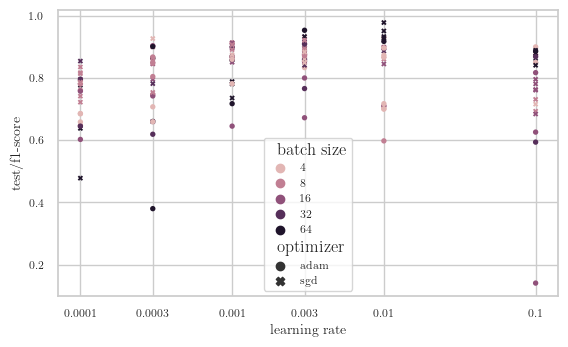

In [6]:
df_prepared = df.rename(columns={'learning_rate': 'learning rate', 'batch_size': 'batch size'})
fig, ax = plt.subplots(1, 1, figsize=set_size(width, subplots=(1,1)))
sns.scatterplot(x="learning rate", y="test/f1-score",
                style="optimizer", hue="batch size",
                palette=sns.cubehelix_palette(5, light=0.8, gamma=1.2),
                sizes=(5, 30), linewidth=0, s=15,
                data=df_prepared, ax=ax)
ax.set_xscale('log')
ax.set_xticks([0.0001, 0.0003, 0.001, 0.003, 0.01, 0.1])
ax.set_xticklabels(labels = ['0.0001', '0.0003', '0.001', '0.003', '0.01', '0.1'])
fig.tight_layout()
fig.savefig(fig_save_dir + 'classifier-hyp-metrics.pdf', format='pdf', bbox_inches='tight')

In [7]:
parameters_dict = {
    'optimizer': {
        'values': ['adam', 'sgd']
    },
}

parameters_dict.update({
    'batch_size': {
        'values': [4, 8, 16, 32, 64]},
    'learning_rate': {
        'values': [0.0001, 0.0003, 0.001, 0.003, 0.01, 0.1]},
    'step_size': {
        'values': [2, 3, 5, 7]},
    'gamma': {
        'values': [0.1, 0.5]},
    'beta_one': {
        'values': [0.9, 0.99]},
    'beta_two': {
        'values': [0.5, 0.9, 0.99, 0.999]},
    'eps': {
        'values': [1e-08, 0.1, 1]}
})

In [8]:
params = pd.DataFrame.from_dict(parameters_dict)
params = params.transpose()
params['values_string'] = [', '.join(map(str, l)) for l in params['values']]
params['values'] = params['values_string']
params = params.drop(['values_string'], axis=1)

In [9]:
params

,values
optimizer,"adam, sgd"
batch_size,"4, 8, 16, 32, 64"
learning_rate,"0.0001, 0.0003, 0.001, 0.003, 0.01, 0.1"
step_size,"2, 3, 5, 7"
gamma,"0.1, 0.5"
beta_one,"0.9, 0.99"
beta_two,"0.5, 0.9, 0.99, 0.999"
eps,"1e-08, 0.1, 1"


In [10]:
pd.DataFrame.from_dict(parameters_dict).explode('optimizer').explode('batch_size').explode('learning_rate').explode('step_size').explode('gamma').explode('beta_one').explode('beta_two').explode('eps')

,optimizer,batch_size,learning_rate,step_size,gamma,beta_one,beta_two,eps
values,adam,4,0.0001,2,0.1,0.9,0.5,0.0
values,adam,4,0.0001,2,0.1,0.9,0.5,0.1
values,adam,4,0.0001,2,0.1,0.9,0.5,1
values,adam,4,0.0001,2,0.1,0.9,0.9,0.0
values,adam,4,0.0001,2,0.1,0.9,0.9,0.1
...,...,...,...,...,...,...,...,...
values,sgd,64,0.1,7,0.5,0.99,0.99,0.1
values,sgd,64,0.1,7,0.5,0.99,0.99,1
values,sgd,64,0.1,7,0.5,0.99,0.999,0.0
values,sgd,64,0.1,7,0.5,0.99,0.999,0.1


# F1-score stratified 10-fold cross validation

In [57]:
f_scores_test = pd.read_csv('f1-scores-folds.csv', delimiter=',')
f_scores_test['epoch'] = np.resize(np.arange(25), 10*25)
f_scores_test['fold'] = np.repeat(np.arange(10), 25)
f_scores_test = pd.melt(f_scores_test[['epoch', 'fold', 'StratifiedKFold-ROC - test/f1-score']], ['epoch', 'fold'])

f_scores_train = pd.read_csv('f1-scores-folds-train.csv', delimiter=',')
f_scores_train['epoch'] = np.resize(np.arange(25), 10*25)
f_scores_train['fold'] = np.repeat(np.arange(10), 25)
f_scores_train = pd.melt(f_scores_train[['epoch', 'fold', 'StratifiedKFold-ROC - train/f1-score']], ['epoch', 'fold'])

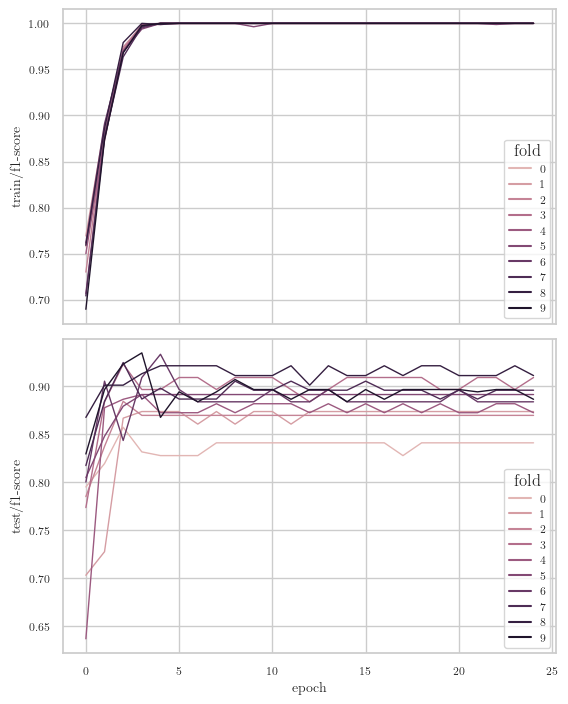

In [66]:
fig, ax = plt.subplots(2, 1, figsize=set_size(width, subplots=(2,1)), sharex=True)
sns.lineplot(x="epoch", y="value",
                hue='fold',
                palette=sns.cubehelix_palette(10, light=0.8, gamma=1.2),
                linewidth=1,
                data=f_scores_train, ax=ax[0])

sns.lineplot(x="epoch", y="value",
                hue='fold',
                palette=sns.cubehelix_palette(10, light=0.8, gamma=1.2),
                linewidth=1,
                data=f_scores_test, ax=ax[1])
ax[0].set_ylabel('train/f1-score')
ax[1].set_ylabel('test/f1-score')
fig.tight_layout()
fig.savefig(fig_save_dir + 'classifier-hyp-folds-f1.pdf', format='pdf', bbox_inches='tight')